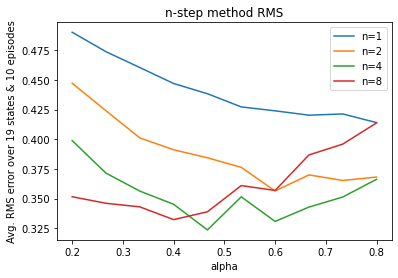

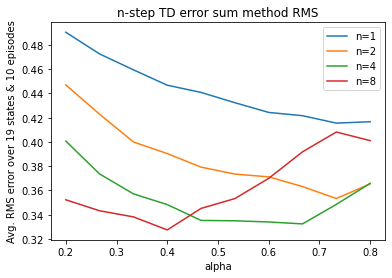

In [166]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

'''
19-state random walk from example 7.1
State-value function evaluated with n-step and sum of TD error methods
Results suggest similar performance across varying parameter values
'''

def train_nstep_TD_sum(pi, alpha, gamma, n, max_episode):
    '''
    Estimate v using n-step TD error sum
    
    Parameters
    ----------       
        pi : func
            Policy to evaluate
        alpha : float
            Convergence parameter
        gamma : float
            Discount parameter
        n : int
            Puts the n in n-step
        max_episode : int
            maximum number of episodes
    Returns
    -------
        ndarray
            state-value function for pi for every episode
    '''
    vs = []
    v = np.zeros(21)
    episode = 0
    
    while episode < max_episode:
        done = False
        st = 3
        s = [st]
        r = [0] # R_0 = 0
        tau = 0
        T = math.inf
        t = 0
        
        while tau != T - 1:
            if t < T:
                a = pi(st)
                st = st + a
                reward = 0
                if st == 0 or st == 20:
                    done = True
                    if st == 20:
                        reward = 1
                    else:
                        reward = -1
                s.append(st)
                r.append(reward)
                if done:
                    T = t + 1
            tau = t - n + 1
            if tau >= 0:
                gammas = np.array([gamma ** (i - tau) for i in range(tau, min(tau + n - 1, T - 1) + 1)])
                deltas = np.array([r[i + 1] + gamma * v[s[i + 1]] - v[s[i]] for i in range(tau, min(tau + n - 1, T - 1) + 1)])
                error = np.sum(gammas * deltas)
                v[s[tau]] = v[s[tau]] + alpha * error
            t += 1
            
        episode += 1
        vs.append(v.copy()[1:-1])
        
    return np.array(vs)

def train_nstep_TD(pi, alpha, gamma, n, max_episode):

    vs = []
    v = np.zeros(21)
    episode = 0
    
    while episode < max_episode:
        done = False
        st = 3
        s = [st]
        r = [0] # R_0 = 0
        tau = 0
        T = math.inf
        t = 0
        
        while tau != T - 1:
            if t < T:
                a = pi(st)
                st = st + a
                reward = 0
                if st == 0 or st == 20:
                    done = True
                    if st == 20:
                        reward = 1
                    else:
                        reward = -1
                s.append(st)
                r.append(reward)
                if done:
                    T = t + 1
            tau = t - n + 1
            if tau >= 0:
                gammas = np.array([gamma ** (i - tau - 1) for i in range(tau + 1, min(tau + n, T) + 1)])
                r_sub = np.array(r[tau + 1:len(gammas) + tau + 1])
                g = np.sum(r_sub * gammas)
                if tau + n < T:
                    g += gamma ** n * v[s[tau + n]]
                v[s[tau]] = v[s[tau]] + alpha * (g - v[s[tau]])
            t += 1

        episode += 1
        vs.append(v.copy()[1:-1])
    
    return np.array(vs)

def parameter_analysis(alphas, ns, v, repeat=100, max_episode=10, gamma=1):
    '''
    Calculate RMS error for varying n, alpha
    
    Each (n,alpha) will be run <repeat> times
    RMS error for (n,alpha) will be over 19 states, <max_episodes> episodes, and <repeat> runs
    '''
    def pi(st):
        # Use a stochastic policy
        return random.choice([-1, 1])
    
    rms1 = np.zeros((len(ns), alphas.size))
    rms2 = np.zeros((len(ns), alphas.size))
    for i, n in enumerate(ns):
        for j, alpha in enumerate(alphas):
            for k in range(repeat):
                vs1 = train_nstep_TD(pi, alpha, gamma, n, max_episode)
                vs2 = train_nstep_TD_sum(pi, alpha, gamma, n, max_episode)
                rms1[i, j] = rms1[i, j] + (np.sum([np.sqrt(np.sum(np.square(val-v))/5) for val in vs1]) / 19 - rms1[i, j]) / (k + 1)
                rms2[i, j] = rms2[i, j] + (np.sum([np.sqrt(np.sum(np.square(val-v))/5) for val in vs2]) / 19 - rms2[i, j]) / (k + 1)
                
    return rms1, rms2

if __name__ == '__main__':
    # Find ground-truth state-values
    d = np.ones((1, 18))[0] / 2
    M = np.diag(d, -1) + np.diag(d, 1)
    M = np.vstack((M, np.zeros((2,19))))
    M = np.hstack((M, np.zeros((21,2))))
    M[19,0] = 0.5
    M[20,18] = 0.5
    M[-1,-1] = 1
    M[-2,-2] = 1
    R = M[19:, :19]
    Q = M[:19, :19]
    It = np.eye(19)
    v = np.matmul(R, np.linalg.inv(It - Q))[1,:] + np.matmul(R, np.linalg.inv(It - Q))[0,:] * -1
    
    # Parameters
    alphas = np.linspace(0.2,0.8,10)
    ns = [1,2,4,8]
    
    rms1, rms2 = parameter_analysis(alphas, ns, v)
    
    plt.figure()
    for i in range(len(ns)):
        plt.plot(alphas, rms1[i,:], label='n={}'.format(ns[i]))

    plt.legend(loc='upper right')
    plt.xlabel('alpha')
    plt.ylabel('Avg. RMS error over 19 states & 10 episodes')
    plt.title('n-step method RMS')
    plt.show()

    plt.figure()
    for i in range(len(ns)):
        plt.plot(alphas, rms2[i,:], label='n={}'.format(ns[i]))

    plt.legend(loc='upper right')
    plt.xlabel('alpha')
    plt.ylabel('Avg. RMS error over 19 states & 10 episodes')
    plt.title('n-step TD error sum method RMS')
    plt.show()